# Modelling

### Import the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")

### Load the data sets

In [2]:
df = pd.read_csv("/content/drive/MyDrive/datasets/downloaded-data/final-cleaned-data/df_lemmatized_masks.csv")

In [3]:
# fallb_df = pd.read_csv("/content/drive/MyDrive/datasets/downloaded-data/final-cleaned-data/clean_fallback_df.csv")

#### Drop the "Unnamed" column.

In [3]:
# drop the Unnamed column
df.drop(df.columns[df.columns.str.contains('Unnamed',case = False)],axis = 1, inplace = True)

In [5]:
# drop the Unnamed column
# fallb_df.drop(fallb_df.columns[fallb_df.columns.str.contains('Unnamed',case = False)],axis = 1, inplace = True)

In [4]:
df.head()

,lemmatized_query
0,abonnement delen
1,abonnement delen
2,deel account
3,gebruiker toevoegen
4,abonnement delen


In [5]:
df.tail()

,lemmatized_query
6356,rijden mee
6357,rijden alleen
6358,werken proefrit
6359,proefrit maken [CAR_MODEL]
6360,[CAR_BRAND]


## Determine the number of clusters to use for the dataframe

In [6]:
# convert the queries into a matrix of TF-IDF features
vectorizer = TfidfVectorizer()

# fit the vectorizer on the preprocessed data
X = vectorizer.fit_transform(df["lemmatized_query"])

In [12]:
# add the masks as additional features (this would be in 1s and 0s, so which row contains a mask and which doesn't)
# masks = df["mask"].values.reshape(-1, 1)
# X = np.hstack((X.toarray(), masks))

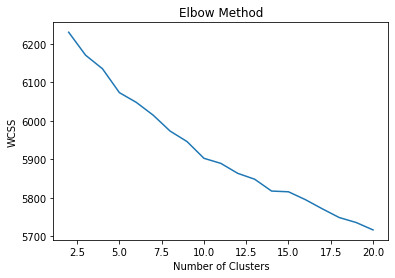

In [7]:
# calculate the within-cluster sum of squares (WCSS) for different numbers of clusters
wcss = []
for i in range(2, 21):
    kmeans = KMeans(n_clusters=i, init="k-means++", max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# plot the elbow curve to visualize the optimal number of clusters
plt.plot(range(2, 21), wcss)
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.show()

### KMeans clustering

In [8]:
# perform clustering with KMeans using the optimal number of clusters
num_clusters = 13
kmeans = KMeans(n_clusters=num_clusters, init="k-means++", max_iter=300, n_init=10, random_state=0)
kmeans.fit(X)

# add the cluster labels to the DataFrame
df["cluster"] = kmeans.labels_

# print how many queries fall into each cluster
print(df["cluster"].value_counts())

6     3492
10     518
5      393
3      353
0      319
12     249
1      199
9      186
8      164
11     154
4      131
7      108
2       95
Name: cluster, dtype: int64


In [10]:
cluster_0 = 3492
total_responses = 6361

round(cluster_0/total_responses,3)

0.549

> Roughly 55% of the queries are assigned to cluster 0, which means the algorithm really couldn't identify much of a difference between those queries.

### Using the 'silhouette_scores' to determine the number of clusters

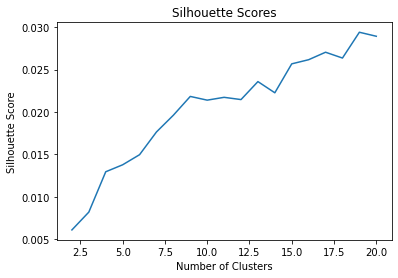

In [11]:
from sklearn.metrics import silhouette_score

silhouette_scores = []

for i in range(2, 21):
    kmeans = KMeans(n_clusters=i, init="k-means++", max_iter=300, n_init=10, random_state=42)
    kmeans.fit(X)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

# plot the silhouette scores for different numbers of clusters
plt.plot(range(2, 21), silhouette_scores)
plt.title("Silhouette Scores")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.show()

In [12]:
# choose the number of clusters with the highest silhouette score
num_clusters = silhouette_scores.index(max(silhouette_scores)) + 2 # loop starts from 2, therefore add 2
print("The optimal number of clusters is:", num_clusters)

The optimal number of clusters is: 19


In [13]:
# perform clustering with KMeans using the optimal number of clusters
kmeans = KMeans(n_clusters=num_clusters, init="k-means++", max_iter=300, n_init=10, random_state=0)
kmeans.fit(X)

KMeans(n_clusters=19, n_init=10, random_state=0)

In [14]:
# add the cluster labels to the DataFrame
df["cluster"] = kmeans.labels_

# print the number of queries in each cluster
print(df["cluster"].value_counts())

1     2933
4      391
3      271
6      270
5      249
0      232
2      212
11     206
13     195
18     178
10     168
16     161
9      159
12     140
7      137
17     121
15     119
8      115
14     104
Name: cluster, dtype: int64


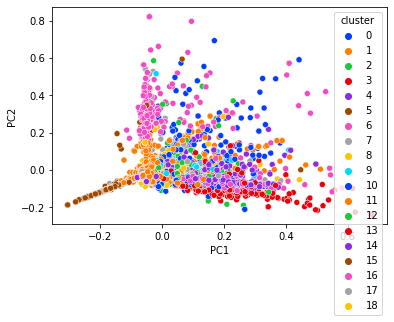

In [15]:
from sklearn.decomposition import PCA
import seaborn as sns

# reduce the dimensionality of the TF-IDF matrix to 2 using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

# add the cluster labels to the PCA-transformed matrix
X_pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
X_pca_df["cluster"] = kmeans.labels_

# plot the clusters using seaborn
sns.scatterplot(data=X_pca_df, x="PC1", y="PC2", hue="cluster", palette="bright")
plt.show()

### Investigating the clusters

In [16]:
df[df["cluster"]==1]["lemmatized_query"].head(10)

3                                   gebruiker toevoegen
9                                  klote digi assistent
12                             wijziging rekeningnummer
13                                 wijziging banknummer
14                                      financile vraag
18    abonnement computer lezen daarvoor website cli...
20                           waar staan [PRODUCT_BRAND]
21                                 buitenlands postcode
24                           wanneer starten abbonement
28    richten bot goed af zorg servicemedewerker ach...
Name: lemmatized_query, dtype: object

In [17]:
df[df["cluster"]==2]["lemmatized_query"].head(10)

7                                        app werken goed
8                                              vraag app
27                               actueel tijdschrift app
126    voucher code invoeren ingnjjtkkt inloggen app ...
197    downloaen tijdschrift heel lang duren app eraf...
254                       app installeren laptop windows
288                            gekeen waarom toegang app
296                                            vraag app
313    waar vinden tijdschrift telefoon gedownload al...
332    vallen ieder keer bepalen tijdschrift laten ap...
Name: lemmatized_query, dtype: object

In [18]:
df[df["cluster"]==3]["lemmatized_query"].tail(10)

4800                              leven mens chat krijgen
4833                 klik link opzeggen krijgen ver beeld
4836              hoi lid worden krijgen alleen flow zien
4837                         hoi krijgen alleen flow zien
4844     waarom krijgen wanneer inlog abbb vraag betaling
5022    zoeken dealer rond zoersel krijgen enkel nerde...
5218                                   bang krass krijgen
5286                       vragen parket krijgen antwoord
5560                              kopen hoog stan krijgen
6016                               antwoord krijgen vraag
Name: lemmatized_query, dtype: object

### Wordcloud for each cluster

In [ ]:
# !pip install wordcloud

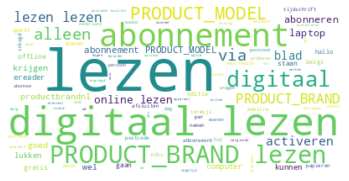

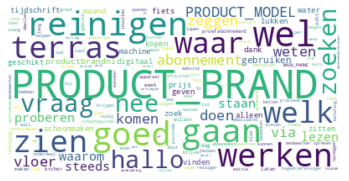

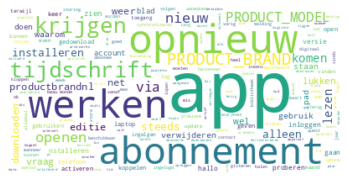

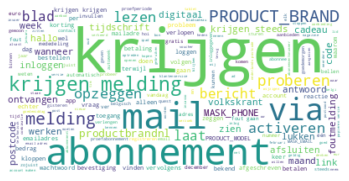

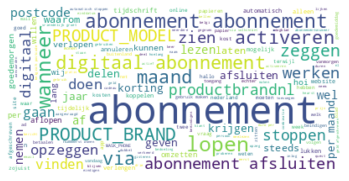

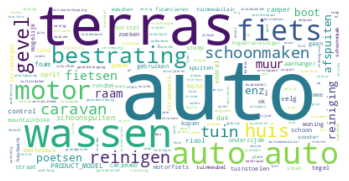

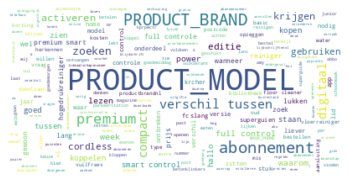

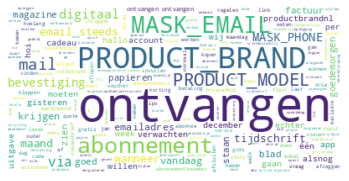

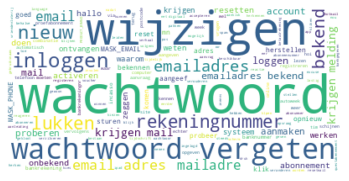

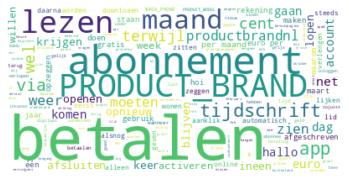

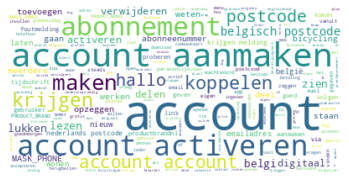

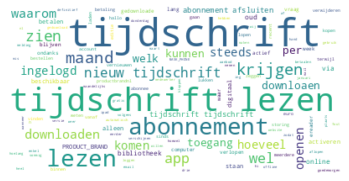

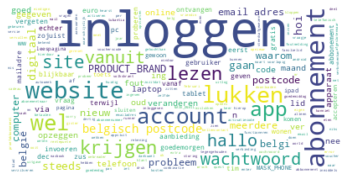

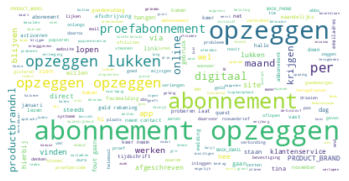

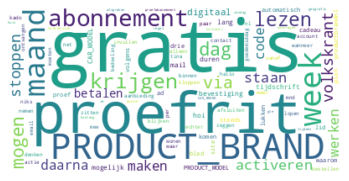

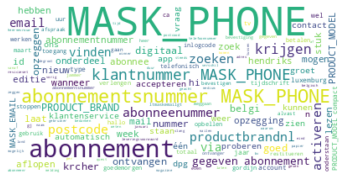

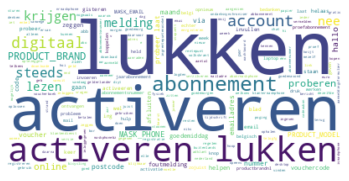

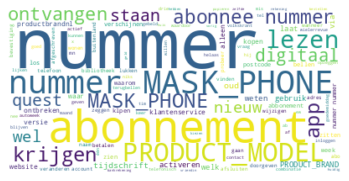

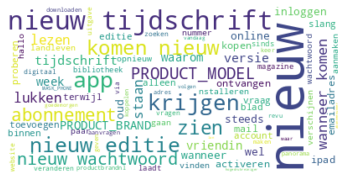

In [23]:
from wordcloud import WordCloud

# generate a word cloud for each cluster
for i in range(num_clusters):
    cluster_df = df[df["cluster"] == i]
    text = " ".join(cluster_df["lemmatized_query"])
    wordcloud = WordCloud(background_color="white").generate(text)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

## Determine the number of clusters to use for the Fallback data frame

In [ ]:
# convert the queries into a matrix of TF-IDF features
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(fallb_df["clean_fallback"])

In [ ]:
# calculate the within-cluster sum of squares (WCSS) for different numbers of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init="k-means++", max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# plot the elbow curve to visualize the optimal number of clusters
plt.plot(range(1, 11), wcss)
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.show()

### KMeans clustering

In [ ]:
# perform clustering with KMeans using the optimal number of clusters
num_clusters = 8
kmeans = KMeans(n_clusters=num_clusters, init="k-means++", max_iter=300, n_init=10, random_state=0)
kmeans.fit(X)

# add the cluster labels to the DataFrame
fallb_df["cluster"] = kmeans.labels_

# print how many queries fall into each cluster
print(fallb_df["cluster"].value_counts())

In [ ]:
cluster_0 = 5399
total_responses = 7581

round(cluster_0/total_responses,3)

> Roughly 71% of the queries are assigned to cluster 0, which means the algorithm really couldn't identify much of a difference between those queries.

### Using the 'silhouette_scores' to determine the number of clusters

In [ ]:
from sklearn.metrics import silhouette_score

silhouette_scores = []

for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init="k-means++", max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

# plot the silhouette scores for different numbers of clusters
plt.plot(range(2, 11), silhouette_scores)
plt.title("Silhouette Scores")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.show()

In [ ]:
# choose the number of clusters with the highest silhouette score
num_clusters = silhouette_scores.index(max(silhouette_scores)) + 2
print("The optimal number of clusters is:", num_clusters)

In [ ]:
# perform clustering with KMeans using the optimal number of clusters
kmeans = KMeans(n_clusters=num_clusters, init="k-means++", max_iter=300, n_init=10, random_state=0)
kmeans.fit(X)

In [ ]:
# add the cluster labels to the DataFrame
fallb_df["cluster"] = kmeans.labels_

# print the number of queries in each cluster
print(fallb_df["cluster"].value_counts())

In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns

# reduce the dimensionality of the TF-IDF matrix to 2 using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

# add the cluster labels to the PCA-transformed matrix
X_pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
X_pca_df["cluster"] = kmeans.labels_

# plot the clusters using seaborn
sns.scatterplot(data=X_pca_df, x="PC1", y="PC2", hue="cluster", palette="bright")
plt.show()

### Investigating the clusters

In [ ]:
fallb_df[fallb_df["cluster"]==1]["clean_fallback"].head(10)

In [ ]:
fallb_df[fallb_df["cluster"]==2]["clean_fallback"].head(10)

In [ ]:
fallb_df[fallb_df["cluster"]==3]["clean_fallback"].head(10)

### Wordcloud for each cluster

In [ ]:
# !pip install wordcloud

In [ ]:
from wordcloud import WordCloud

# generate a word cloud for each cluster
for i in range(num_clusters):
    cluster_df = fallb_df[fallb_df["cluster"] == i]
    text = " ".join(cluster_df["clean_fallback"])
    wordcloud = WordCloud(background_color="white").generate(text)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

## BERTopic 

### Installing the BERTopic

In [24]:
!pip install bertopic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.7/120.7 KB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 13.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 55.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 107.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 75.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  

In [25]:
# extract the queries to a list of strings
queries = df["clean_query"].tolist()

KeyError: ignored

In [ ]:
from bertopic import BERTopic

# initialize BERTopic model and fit_transform the data
topic_model = BERTopic(language="multilingual", calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(queries)

In [ ]:
# access the frequent topics
topic_model.get_topic_info()

> -1 refers to all outliers and should typically be ignored.

In [ ]:
# most frequent topic that was generated, topic 0
topic_model.get_topic(0)

> Using `.get_document_info`, can extract information on a document level, such as their corresponding topics, probabilities, whether they are representative documents for a topic, etc.

In [ ]:
topic_model.get_document_info(queries)

In [ ]:
# print the top topics and associated keywords
print(topic_model.get_topic_freq())

In [ ]:
# get the topic distribution for each query
topic_distributions = topic_model.transform(queries)

In [ ]:
# print the topic distribution for the first query
print(topic_distributions[0])

## LDA

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation as LDA

In [ ]:
# convert the data to a list
queries = fallb_df["clean_fallback"].tolist()

In [ ]:
# create a CountVectorizer to convert the queries to numerical vectors
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(queries)

In [ ]:
# Helper function
def print_topics(model, n_top_words):
    words = vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [ ]:
# Tweak the two parameters below (use int values below 15)
number_topics = 10
number_words = 10

# Create and fit the LDA model
lda = LDA(n_components=number_topics)
lda.fit(X)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, number_words)

In [ ]:
# create the LDA model
lda = LatentDirichletAllocation(n_components=None, random_state=0)

In [ ]:
# fit the model to your data and get the number of topics
lda.fit(X)

In [ ]:
# get the top words for each topic

feature_names = vectorizer.get_feature_names()

topic_top_words = []

for topic_idx, topic in enumerate(lda.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-6:-1]]
    topic_top_words.append(', '.join(top_words))

In [ ]:
# Assign labels to your data based on the topics
topics = lda.transform(X).argmax(axis=1)
data['topic'] = topics